# Translation (PyTorch)

Installing the Transformers, Datasets, and Evaluate libraries to run this notebook.

In [ ]:
#Installation des bibliothèques nécessaires
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate
!pip install sacrebleu
# To run the training on TPU, you will need to uncomment the following line:
# !pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!apt install git-all

In [ ]:
!pip install sacremoses

logging in in to the Hugging Face Hub

In [ ]:

# Connexion au Hugging Face Hub
from huggingface_hub import notebook_login

notebook_login()

# **Preparation de la data:**

In [ ]:
# Chargement des jeux de données KDE4
from datasets import load_dataset

raw_datasets = load_dataset("kde4", lang1="en", lang2="fr")

Generating train split:   0%|          | 0/210173 [00:00<?, ? examples/s]

Jetons un coup d’œil au jeu de données :

In [ ]:
#Taking a look at the dataset
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 210173
    })
})

Nous avons 210 173 paires de phrases. Cependant regroupées dans un seul échantillon. Nous devrons donc créer notre propre jeu de validation.

In [ ]:
# Division du jeu de données en ensembles d'entraînement et de validation
split_datasets = raw_datasets["train"].train_test_split(train_size=0.9, seed=20)
split_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 189155
    })
    test: Dataset({
        features: ['id', 'translation'],
        num_rows: 21018
    })
})

On peut aussi renommer le set de "train" pour qu'il devienne "validation" comme suit:

In [ ]:
split_datasets["validation"] = split_datasets.pop("test")

Examinons maintenant un élément de ce jeu de données :

In [ ]:
# Exemple d'accès à une paire de phrases de traduction
split_datasets["train"][1]["translation"]

{'en': 'Default to expanded threads',
 'fr': 'Par défaut, développer les fils de discussion'}

Nous obtenons un dictionnaire contenant deux phrases dans la paire de langues qui nous intéresse. Une particularité de ce jeu de données rempli de termes techniques informatiques est qu’ils sont tous entièrement traduits en français.

Içi, on fait appel au modele MarianMT pré-entrainé avec la dataset OPUS initiallement que pour demonstration pour montrer que la dataset KDE4 (avec laquelle nous allons travailler) traduit les termes techniques et scientifiques en français, tandis que la dataset OPUS préserve les termes techniques dans leur langue d'origine "l'anglais".

In [ ]:
# Importation d'un pipeline pour la traduction
from transformers import pipeline

model_checkpoint = "Helsinki-NLP/opus-mt-en-fr"
translator = pipeline("translation", model=model_checkpoint)
translator("Default to expanded threads")

[{'translation_text': 'Par défaut pour les threads élargis'}]

Un autre exemple de ce comportement peut être observé avec le mot « plugin » qui n’est pas officiellement un mot français mais que la plupart des francophones comprendront et ne prendront pas la peine de traduire. Dans le jeu de données KDE4, ce mot a été traduit en français par le plus officiel « module d’extension » :

In [ ]:
# Exemple de traduction avec le pipeline
split_datasets["train"][172]["translation"]

{'en': 'Unable to import %1 using the OFX importer plugin. This file is not the correct format.',
 'fr': "Impossible d'importer %1 en utilisant le module d'extension d'importation OFX. Ce fichier n'a pas un format correct."}

In [ ]:
translator(
    "Unable to import %1 using the OFX importer plugin. This file is not the correct format."
)

[{'translation_text': "Impossible d'importer %1 en utilisant le plugin d'importateur OFX. Ce fichier n'est pas le bon format."}]

# **Pré-traitement de la data**

In [ ]:
# Création du tokenizer
from transformers import AutoTokenizer

model_checkpoint = "Helsinki-NLP/opus-mt-en-fr"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, return_tensors="pt")

Ainsi, le prétraitement d’un échantillon ressemble à ceci :

In [ ]:
# Encodage d'une paire de phrases en anglais et en français pour le modèle
en_sentence = split_datasets["train"][1]["translation"]["en"]
fr_sentence = split_datasets["train"][1]["translation"]["fr"]

inputs = tokenizer(en_sentence, text_target=fr_sentence)
inputs

{'input_ids': [47591, 12, 9842, 19634, 9, 0], 'attention_mask': [1, 1, 1, 1, 1, 1], 'labels': [577, 5891, 2, 3184, 16, 2542, 5, 1710, 0]}

Si nous oublions de tokeniser les cibles dans le gestionnaire de contexte, elles seront tokenisées par le tokenizer d’entrée, ce qui dans le cas d’un modèle Marian, ne va pas du tout bien se passer :

In [ ]:
wrong_targets = tokenizer(fr_sentence)
print(tokenizer.convert_ids_to_tokens(wrong_targets["input_ids"]))
print(tokenizer.convert_ids_to_tokens(inputs["labels"]))

['▁Par', '▁dé', 'f', 'aut', ',', '▁dé', 've', 'lop', 'per', '▁les', '▁fil', 's', '▁de', '▁discussion', '</s>']
['▁Par', '▁défaut', ',', '▁développer', '▁les', '▁fils', '▁de', '▁discussion', '</s>']


Comme on peut le voir, utiliser le tokenizer anglais pour prétraiter une phrase française donne un batch de tokens plus important, puisque le tokenizer ne connaît aucun mot français (sauf ceux qui apparaissent aussi en anglais, comme « discussion »).

Les inputs et les targets sont des dictionnaires avec nos clés habituelles (identifiants d’entrée, masque d’attention, etc.). La dernière étape est de définir une clé "labels" dans les entrées. Nous faisons cela dans la fonction de prétraitement que nous allons appliquer sur les jeux de données :

In [ ]:
max_length = 128


def preprocess_function(examples):
    inputs = [ex["en"] for ex in examples["translation"]]
    targets = [ex["fr"] for ex in examples["translation"]]
    model_inputs = tokenizer(
        inputs, text_target=targets, max_length=max_length, truncation=True
    )
    return model_inputs

Veuillez noter que nous avons défini la même longueur maximale pour nos entrées et nos sorties. Étant donné que les textes avec lesquels nous travaillons semblent assez courts, nous utilisons une longueur de 128.

Nous pouvons maintenant appliquer ce prétraitement en une seule fois sur toutes les subdivisions de notre jeu de données :

In [ ]:
tokenized_datasets = split_datasets.map(
    preprocess_function,
    batched=True,
    remove_columns=split_datasets["train"].column_names,
)

Map:   0%|          | 0/189155 [00:00<?, ? examples/s]

Map:   0%|          | 0/21018 [00:00<?, ? examples/s]

Maintenant que les données ont été prétraitées, nous sommes prêts à fine-tuner notre modèle pré-entraîné !

# **Graphiques et visualisations de données**

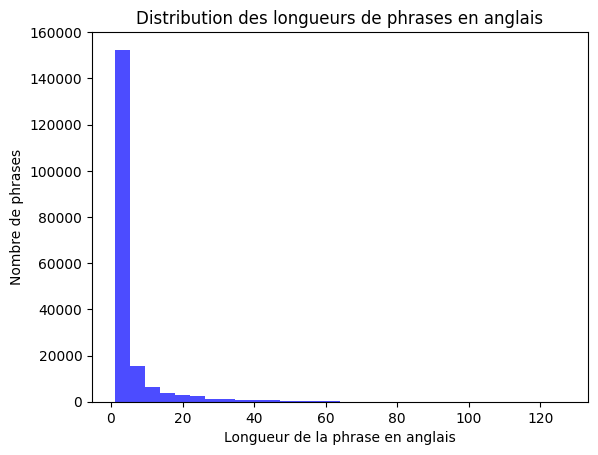

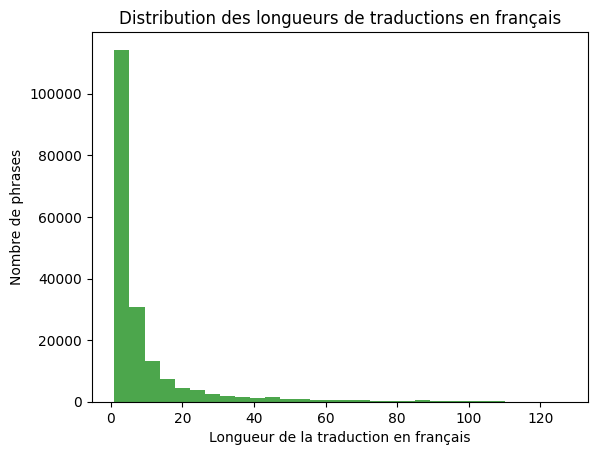

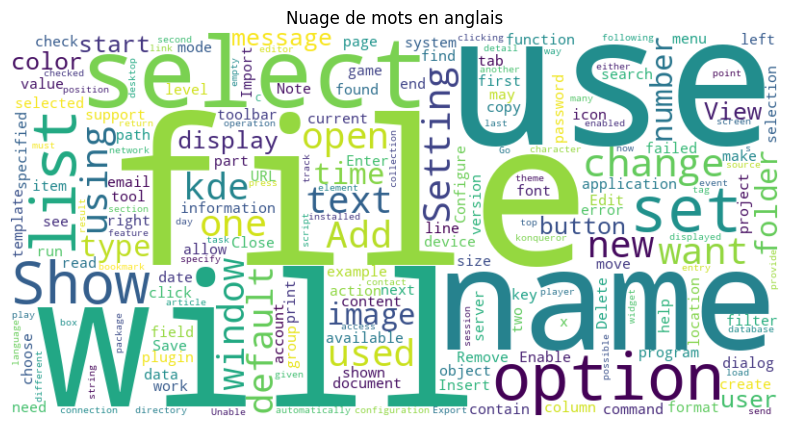

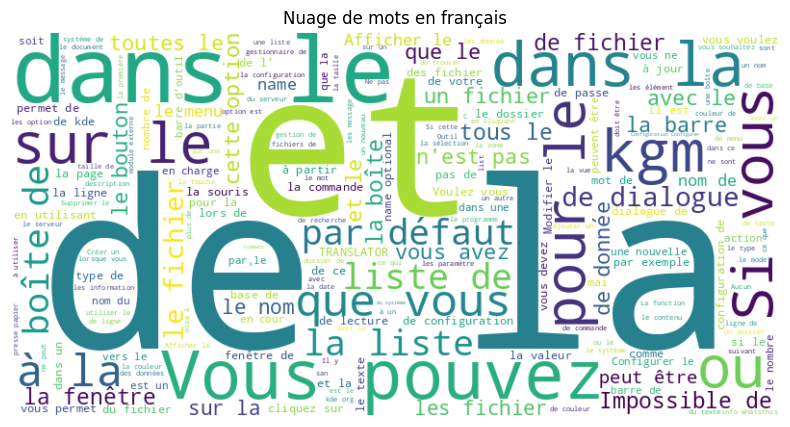

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Assuming 'train' is the key for individual examples
train_examples = tokenized_datasets['train']

# Extract original English and French sentences from the tokenized data
en_sentences = [tokenizer.decode(example['input_ids'], skip_special_tokens=True) for example in train_examples]
fr_sentences = [tokenizer.decode(example['labels'], skip_special_tokens=True) for example in train_examples]

# Histogramme de Longueurs de Phrases en Anglais
en_lengths = [len(sentence.split()) for sentence in en_sentences]
plt.hist(en_lengths, bins=30, color='blue', alpha=0.7)
plt.xlabel('Longueur de la phrase en anglais')
plt.ylabel('Nombre de phrases')
plt.title('Distribution des longueurs de phrases en anglais')
plt.show()

# Histogramme de Longueurs de Traductions en Français
fr_lengths = [len(sentence.split()) for sentence in fr_sentences]
plt.hist(fr_lengths, bins=30, color='green', alpha=0.7)
plt.xlabel('Longueur de la traduction en français')
plt.ylabel('Nombre de phrases')
plt.title('Distribution des longueurs de traductions en français')
plt.show()

# Nuage de Mots en Anglais
en_text = ' '.join(en_sentences)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(en_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuage de mots en anglais')
plt.show()

# Nuage de Mots en Français
fr_text = ' '.join(fr_sentences)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(fr_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuage de mots en français')
plt.show()


# **Finetuner le modèle avec l'API Trainer**

Le code actuel utilisant Trainer sera le même que précédemment, avec juste un petit changement : nous utilisons ici Seq2SeqTrainer qui est une sous-classe de Trainer qui nous permet de traiter correctement l’évaluation, en utilisant la méthode generate() pour prédire les sorties à partir des entrées. Nous y reviendrons plus en détail lorsque nous parlerons du calcul de la métrique.

Tout d’abord, nous avons besoin d’un modèle à finetuner. Nous allons utiliser l’API habituelle AutoModel :

In [ ]:
# Importation du modèle de séquence à séquence
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

Notez que cette fois-ci, nous utilisons un modèle qui a été entraîné sur une tâche de traduction et qui peut déjà être utilisé, donc il n’y a pas d’avertissement concernant les poids manquants ou ceux nouvellement initialisés.

Nous aurons besoin d’un assembleur de données pour gérer le rembourrage pour la mise en batchs dynamique.

In [ ]:
# Importation du DataCollator pour le modèle
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

Pour le tester sur quelques échantillons, nous l’appelons simplement sur une liste d’exemples de notre échantillon d’entrainement tokénisé :

In [ ]:
batch = data_collator([tokenized_datasets["train"][i] for i in range(1, 3)])
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])

Nous pouvons vérifier que nos étiquettes ont été rembourrées à la longueur maximale du batch, en utilisant -100 :

In [ ]:
batch["labels"]

tensor([[  577,  5891,     2,  3184,    16,  2542,     5,  1710,     0,  -100,
          -100,  -100,  -100,  -100,  -100,  -100],
        [ 1211,     3,    49,  9409,  1211,     3, 29140,   817,  3124,   817,
           550,  7032,  5821,  7907, 12649,     0]])

Nous pouvons aussi jeter un coup d’œil aux identifiants d’entrée du décodeur, pour voir qu’il s’agit de versions décalées des étiquettes :

In [ ]:
batch["decoder_input_ids"]

tensor([[59513,   577,  5891,     2,  3184,    16,  2542,     5,  1710,     0,
         59513, 59513, 59513, 59513, 59513, 59513],
        [59513,  1211,     3,    49,  9409,  1211,     3, 29140,   817,  3124,
           817,   550,  7032,  5821,  7907, 12649]])

Voici les étiquettes des premier et deuxième éléments de notre jeu de données :

In [ ]:
for i in range(1, 3):
    print(tokenized_datasets["train"][i]["labels"])

[577, 5891, 2, 3184, 16, 2542, 5, 1710, 0]
[1211, 3, 49, 9409, 1211, 3, 29140, 817, 3124, 817, 550, 7032, 5821, 7907, 12649, 0]


Nous allons transmettre ce data_collator au Seq2SeqTrainer. Ensuite, jetons un coup d’oeil à la métrique.

# **Métriques**

In [ ]:
# Initialisation de l'évaluation avec le métrique BLEU
import evaluate

metric = evaluate.load("sacrebleu")

Cette métrique prend des textes comme entrées et cibles. Elle est conçue pour accepter plusieurs cibles acceptables car il y a souvent plusieurs traductions possibles d’une même phrase. Le jeu de données que nous utilisons n’en fournit qu’une seule.

Essayons un exemple :

In [ ]:
predictions = [
    "This plugin lets you translate web pages between several languages automatically."
]
references = [
    [
        "This plugin allows you to automatically translate web pages between several languages."
    ]
]
metric.compute(predictions=predictions, references=references)

{'score': 46.750469682990165,
 'counts': [11, 6, 4, 3],
 'totals': [12, 11, 10, 9],
 'precisions': [91.66666666666667,
  54.54545454545455,
  40.0,
  33.333333333333336],
 'bp': 0.9200444146293233,
 'sys_len': 12,
 'ref_len': 13}

Cela donne un score BLEU de 46.75, ce qui est plutôt bon.

D’autre part, si nous essayons avec les deux mauvais types de prédictions (répétitions ou prédiction trop courte) qui sortent souvent des modèles de traduction, nous obtiendrons des scores BLEU plutôt mauvais :

In [ ]:
predictions = ["This This This This"]
references = [
    [
        "This plugin allows you to automatically translate web pages between several languages."
    ]
]
metric.compute(predictions=predictions, references=references)

{'score': 1.683602693167689,
 'counts': [1, 0, 0, 0],
 'totals': [4, 3, 2, 1],
 'precisions': [25.0, 16.666666666666668, 12.5, 12.5],
 'bp': 0.10539922456186433,
 'sys_len': 4,
 'ref_len': 13}

In [ ]:
predictions = ["This plugin"]
references = [
    [
        "This plugin allows you to automatically translate web pages between several languages."
    ]
]
metric.compute(predictions=predictions, references=references)

{'score': 0.0,
 'counts': [2, 1, 0, 0],
 'totals': [2, 1, 0, 0],
 'precisions': [100.0, 100.0, 0.0, 0.0],
 'bp': 0.004086771438464067,
 'sys_len': 2,
 'ref_len': 13}

Le score peut aller de 0 à 100. Plus il est élevé, mieux c’est.

Pour passer des sorties du modèle aux textes utilisables par la métrique, nous allons utiliser la méthode tokenizer.batch_decode(). Nous devons juste nettoyer tous les -100 dans les étiquettes. Le tokenizer fera automatiquement la même chose pour le token de padding :

In [ ]:
import numpy as np


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    # In case the model returns more than the prediction logits
    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100s in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    return {"bleu": result["score"]}

Maintenant que c’est fait, nous sommes prêts à finetuner notre modèle !

# **Finetuner le modèle**

La première étape consiste à se connecter à Hugging Face, afin de pouvoir télécharger vos résultats sur le Hub. Il y a une fonction pratique pour vous aider à le faire dans un notebook :

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Cela affichera un widget où vous pourrez entrer vos identifiants de connexion à Hugging Face.

In [ ]:
from transformers import Seq2SeqTrainingArguments

args = Seq2SeqTrainingArguments(
    f"marian-finetuned-kde4-en-to-fr",
    evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=True,
)

En dehors des hyperparamètres habituels (comme le taux d’apprentissage, le nombre d’époques, la taille des batchs et une le taux de décroissance des poids), voici quelques changements par rapport à ce que nous avons vu dans les sections précédentes :

* Nous ne définissons pas d’évaluation car elle prend du temps. Nous allons juste évaluer une fois notre modèle avant l’entraînement et après.
* Nous avons mis fp16=True, ce qui accélère l’entraînement sur les GPUs modernes.
* Nous définissons predict_with_generate=True, comme discuté ci-dessus.
* Nous utilisons push_to_hub=True pour télécharger le modèle sur le Hub à la fin de chaque époque.


Enfin, nous passons tout au Seq2SeqTrainer :

In [ ]:
# Création de l'objet Seq2SeqTrainer pour l'entraînement
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Cloning https://huggingface.co/yasmineelabbar/marian-finetuned-kde4-en-to-fr into local empty directory.


Download file pytorch_model.bin:   0%|          | 16.5k/285M [00:00<?, ?B/s]

Download file training_args.bin: 100%|##########| 4.06k/4.06k [00:00<?, ?B/s]

Clean file training_args.bin:  25%|##4       | 1.00k/4.06k [00:00<?, ?B/s]

Download file runs/Aug21_11-34-13_890f40b707cd/events.out.tfevents.1692624742.890f40b707cd.630.1: 100%|#######…

Clean file runs/Aug21_11-34-13_890f40b707cd/events.out.tfevents.1692624742.890f40b707cd.630.1: 100%|##########…

Download file runs/Aug21_11-34-13_890f40b707cd/events.out.tfevents.1692619286.890f40b707cd.630.0: 100%|#######…

Clean file runs/Aug21_11-34-13_890f40b707cd/events.out.tfevents.1692619286.890f40b707cd.630.0:   9%|9         …

Download file target.spm:   0%|          | 3.40k/784k [00:00<?, ?B/s]

Download file source.spm:   1%|          | 7.40k/760k [00:00<?, ?B/s]

Clean file target.spm:   0%|          | 1.00k/784k [00:00<?, ?B/s]

Clean file source.spm:   0%|          | 1.00k/760k [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/285M [00:00<?, ?B/s]

Avant d’entraîner, nous allons d’abord regarder le score obtenu par notre modèle, pour vérifier que nous n’aggravons pas les choses avec notre finetuning. Cette commande va prendre un peu de temps, vous pouvez donc prendre un café pendant qu’elle s’exécute :

In [ ]:
# Évaluation du modèle avant l'entraînement
trainer.evaluate(max_length=max_length)

{'eval_loss': 1.696446180343628,
 'eval_bleu': 39.166011386870395,
 'eval_runtime': 1612.519,
 'eval_samples_per_second': 13.034,
 'eval_steps_per_second': 0.204}

Un score BLEU de 39 n’est pas trop mauvais, ce qui reflète le fait que notre modèle est déjà bon pour traduire des phrases anglaises en phrases françaises.

Vient ensuite l’entraînement, qui prendra également un peu de temps :

In [ ]:
# Entraînement du modèle
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,1.423400
1000,1.233600
1500,1.184600
2000,1.125000
2500,1.113000
3000,1.070500
3500,1.063300
4000,1.031900
4500,1.017900
5000,1.008200


Adding files tracked by Git LFS: ['source.spm', 'target.spm']. This may take a bit of time if the files are large.


TrainOutput(global_step=17736, training_loss=0.9375088183687353, metrics={'train_runtime': 3500.8443, 'train_samples_per_second': 162.094, 'train_steps_per_second': 5.066, 'total_flos': 1.1305306504691712e+16, 'train_loss': 0.9375088183687353, 'epoch': 3.0})

In [ ]:
# Évaluation du modèle après l'entraînement
trainer.evaluate(max_length=max_length)

{'eval_loss': 0.8555734753608704,
 'eval_bleu': 52.88529894542656,
 'eval_runtime': 1550.2196,
 'eval_samples_per_second': 13.558,
 'eval_steps_per_second': 0.212,
 'epoch': 3.0}

Enfin, nous utilisons la méthode push_to_hub() pour nous assurer que nous téléchargeons la dernière version du modèle.

In [ ]:
# Envoi du modèle vers le Hugging Face Hub
trainer.push_to_hub(tags="translation", commit_message="Training complete")

To https://huggingface.co/yasmineelabbar/marian-finetuned-kde4-en-to-fr
   2c0047b..04688d6  main -> main

   2c0047b..04688d6  main -> main

To https://huggingface.co/yasmineelabbar/marian-finetuned-kde4-en-to-fr
   04688d6..15b1937  main -> main

   04688d6..15b1937  main -> main



'https://huggingface.co/yasmineelabbar/marian-finetuned-kde4-en-to-fr/commit/04688d6284358cae46fada54177a9071ad2b4643'

# Visualisation du training loss pendant l'entrainement:

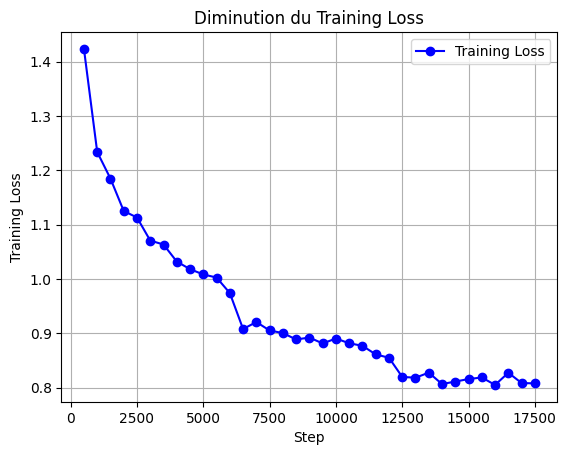

In [ ]:
import matplotlib.pyplot as plt

# Données : Step et Training Loss
steps = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 14000, 14500, 15000, 15500, 16000, 16500, 17000, 17500]
training_loss = [1.4234, 1.2336, 1.1846, 1.125, 1.113, 1.0705, 1.0633, 1.0319, 1.0179, 1.0082, 1.0025, 0.9739, 0.9077, 0.9206, 0.905, 0.9003, 0.8885, 0.892, 0.8812, 0.8902, 0.8815, 0.8768, 0.861, 0.8548, 0.8195, 0.8181, 0.8274, 0.8064, 0.811, 0.8156, 0.8185, 0.8048, 0.8272, 0.8083, 0.8076]

# Création de la courbe
plt.plot(steps, training_loss, marker='o', color='blue', label='Training Loss')
plt.xlabel('Step')
plt.ylabel('Training Loss')
plt.title('Diminution du Training Loss')
plt.legend()
plt.grid(True)
plt.show()


# **Une boucle d'entraînement personnalisée**

D’abord, nous allons construire le DataLoader à partir de nos jeux de données, après avoir configuré les jeux de données au format "torch" pour obtenir les tenseurs PyTorch :

In [ ]:
from torch.utils.data import DataLoader

tokenized_datasets.set_format("torch")
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], collate_fn=data_collator, batch_size=8
)

Ensuite, nous réinstantifions notre modèle pour nous assurer que nous ne poursuivons pas le finetuning précédent et que nous repartons du modèle pré-entraîné :

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

Nous aurons alors besoin d’un optimiseur :

In [ ]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Une fois que nous avons tous ces objets, nous pouvons les envoyer à la méthode accelerator.prepare().

In [ ]:
# Training using the accelerate library for distributed training
from accelerate import Accelerator

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

Maintenant que nous avons envoyé notre train_dataloader à accelerator.prepare(), nous pouvons utiliser sa longueur pour calculer le nombre d’étapes d’entraînement. Rappelez-vous que nous devrions toujours faire cela après avoir préparé le chargeur de données car cette méthode va changer la longueur du DataLoader. Nous utilisons un programme linéaire classique du taux d’apprentissage à 0 :

In [ ]:
from transformers import get_scheduler

num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

Enfin, pour pousser notre modèle vers le Hub, nous aurons besoin de créer un objet Repository dans un dossier de travail.

In [ ]:
from huggingface_hub import Repository, get_full_repo_name

model_name = "marian-finetuned-kde4-en-to-fr-accelerate"
repo_name = get_full_repo_name(model_name)
repo_name

'yasmineelabbar/marian-finetuned-kde4-en-to-fr-accelerate'

Ensuite, nous pouvons cloner ce dépôt dans un dossier local. S’il existe déjà, ce dossier local doit être un clone du dépôt avec lequel nous travaillons :

In [ ]:
output_dir = "marian-finetuned-kde4-en-to-fr-accelerate"
repo = Repository(output_dir, clone_from=repo_name)

Cloning https://huggingface.co/yasmineelabbar/marian-finetuned-kde4-en-to-fr-accelerate into local empty directory.


Nous pouvons maintenant télécharger tout ce que nous sauvegardons dans output_dir en appelant la méthode repo.push_to_hub(). Cela nous aidera à télécharger les modèles intermédiaires à la fin de chaque époque.

# **Boucle d'entraînement complète**





nous définissons cette fonction postprocess() qui prend les prédictions et les étiquettes et les convertit en listes de chaînes de caractères que notre objet metric attend :

In [ ]:
def postprocess(predictions, labels):
    predictions = predictions.cpu().numpy()
    labels = labels.cpu().numpy()

    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels]
    return decoded_preds, decoded_labels

In [ ]:
from tqdm.auto import tqdm
import torch

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for batch in train_dataloader:
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    for batch in tqdm(eval_dataloader):
        with torch.no_grad():
            generated_tokens = accelerator.unwrap_model(model).generate(
                batch["input_ids"],
                attention_mask=batch["attention_mask"],
                max_length=128,
            )
        labels = batch["labels"]

        # Necessary to pad predictions and labels for being gathered
        generated_tokens = accelerator.pad_across_processes(
            generated_tokens, dim=1, pad_index=tokenizer.pad_token_id
        )
        labels = accelerator.pad_across_processes(labels, dim=1, pad_index=-100)

        predictions_gathered = accelerator.gather(generated_tokens)
        labels_gathered = accelerator.gather(labels)

        decoded_preds, decoded_labels = postprocess(predictions_gathered, labels_gathered)
        metric.add_batch(predictions=decoded_preds, references=decoded_labels)

    results = metric.compute()
    print(f"epoch {epoch}, BLEU score: {results['score']:.2f}")

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
        repo.push_to_hub(
            commit_message=f"Training in progress epoch {epoch}", blocking=False
        )

  0%|          | 0/47290 [00:00<?, ?it/s]

  0%|          | 0/2628 [00:00<?, ?it/s]

epoch 0, BLEU score: 51.85


Adding files tracked by Git LFS: ['source.spm', 'target.spm']. This may take a bit of time if the files are large.


  0%|          | 0/2628 [00:00<?, ?it/s]

epoch 1, BLEU score: 52.98


**Visualisation de l'évolution du score BLEU:**

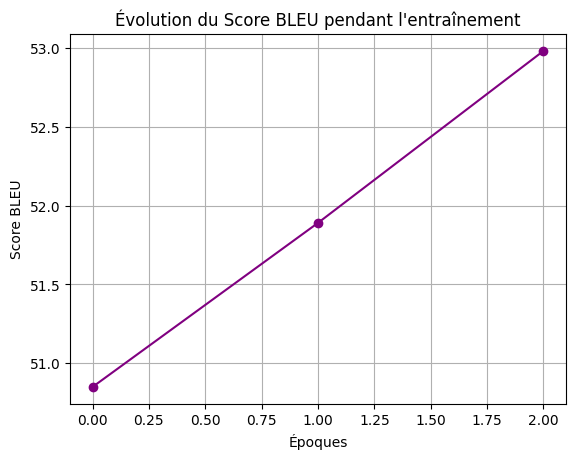

In [ ]:
import matplotlib.pyplot as plt

# Liste des scores BLEU à chaque époque
bleu_scores = [50.85, 51.89, 52.98]

# Liste des époques correspondantes
epochs = [0, 1, 2]

# Tracer la courbe en mauve
plt.plot(epochs, bleu_scores, marker='o', color='purple')

# Ajouter des labels et un titre
plt.xlabel('Époques')
plt.ylabel('Score BLEU')
plt.title('Évolution du Score BLEU pendant l\'entraînement')

# Activer la grille
plt.grid(True)

# Afficher la courbe
plt.show()


# **Utilisation du modèle finetuné**

In [ ]:
from transformers import pipeline

# Replace this with your own checkpoint
model_checkpoint = "yasmineelabbar/marian-finetuned-kde4-en-to-fr"
translator = pipeline("translation", model=model_checkpoint)
translator("Default to expanded threads")

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


[{'translation_text': 'Par défaut, développer les fils de discussion'}]

Comme prévu, notre modèle pré-entraîné a adapté ses connaissances au corpus sur lequel nous l’avons finetuné. Et au lieu de laisser le mot anglais « threads », le modèle le traduit maintenant par la version française officielle. Il en va de même pour « plugin » :

In [ ]:
from transformers import MarianMTModel, MarianTokenizer

model_name = "yasmineelabbar/marian-finetuned-kde4-en-to-fr-accelerate"
model = MarianMTModel.from_pretrained(model_name)
tokenizer = MarianTokenizer.from_pretrained(model_name)

source_text_fr = "Bonjour, comment ça va?"
inputs_fr = tokenizer(source_text_fr, return_tensors="pt", padding="max_length", truncation=True)
translated_ids_en = model.generate(**inputs_fr)
translated_text_en = tokenizer.batch_decode(translated_ids_en, skip_special_tokens=True)[0]

print("Translated to English:", translated_text_en)


Translated to English: Bonjour, commentaireça va & #160;?


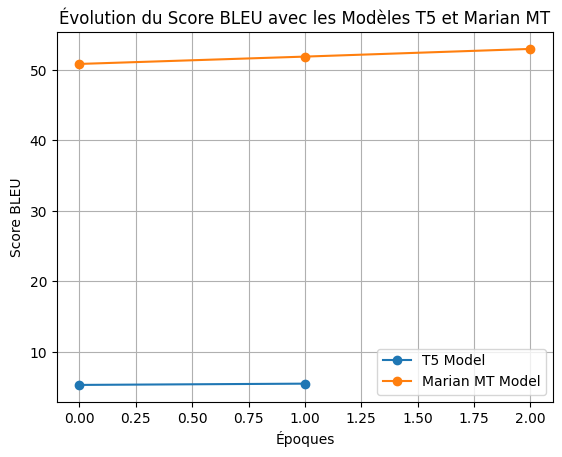

In [ ]:
import matplotlib.pyplot as plt

# Données pour le modèle T5
epochs_t5 = [0, 1]
bleu_scores_t5 = [5.31, 5.49]

# Données pour le modèle Marian MT
epochs_marian = [0, 1, 2]
bleu_scores_marian = [50.85, 51.89, 52.98]

plt.plot(epochs_t5, bleu_scores_t5, marker='o', label='T5 Model')
plt.plot(epochs_marian, bleu_scores_marian, marker='o', label='Marian MT Model')

plt.xlabel('Époques')
plt.ylabel('Score BLEU')
plt.title('Évolution du Score BLEU avec les Modèles T5 et Marian MT')
plt.legend()
plt.grid(True)
plt.show()
